#  Converting between global and local axis systems

IN: MDCM charges, atom positions (from cube file), reference frames   
OUT: MDCM charges shifted to reflect the new local axis system

## 1. Load initial variables
Note: in this code, atoms are 0 indexed
For the MDCM module in CHARMM the atoms are labelled from 1

In [150]:
import numpy as np
import os, sys
from scipy.spatial import distance
import matplotlib.pyplot as plt

home_path = "/home/unibas/boittier/AdjustReferenceSystem/"
sys.path.insert(1, home_path)
from Cube import read_charges_refined, read_cube


BOHR_TO_ANGSTROM = 0.529177

#  Define Variables

# # F-butadiene example
# folder = "fbuta/pos1/"
# xyz_file_name = home_path + folder + "36_charges_refined.xyz"
# pcube = home_path + folder + "B.p.cube"0.529177
# frame_file = home_path + folder + "frames.txt"

# Water Example
folder = "water/"

xyz_file_name = home_path + folder + "8_charges_refined.xyz"
pcube = home_path + folder + "Water_5_5_4.pot.cube"
frame_file = home_path + folder + "frames.txt"

# Open XYZ file
xyz_file = open(xyz_file_name).readlines()
#  read number of charges from first line (xyz format)
n_charges = int(xyz_file[0])
charge_lines = xyz_file[2:n_charges+2]
# Read atoms and charges
c_positions = []
c_charges = []
for charge in charge_lines:
    on, x, y, z, c = charge.split()
    c_positions.append([float(x), float(y) , float(z)])
    c_charges.append(float(c))
    
# Open Cube file
pcube_data, pcube_meta = read_cube(pcube)
atom_positions = []
atom_names = []
for i in pcube_meta["atoms"]:
    atom = list(i[1])
    atom_positions.append([x *BOHR_TO_ANGSTROM for x in atom[1:]])

    atom_names.append(atom[1])
n_atoms = len(atom_names)

# Match each charge to a nucleus
charge_atom_associations = []
atom_charge_dict = {}
for i_charge in range(n_charges):
    min_distance = np.Inf #  initial distance, which can be compared to find smaller values
    for j_atom in range(n_atoms):       
        d = distance.euclidean(c_positions[i_charge], atom_positions[j_atom])
        if d < min_distance:
            atom_association = j_atom
            min_distance = d
    charge_atom_associations.append([i_charge, atom_association])
    
    if atom_association not in list(atom_charge_dict.keys()):
        atom_charge_dict[atom_association] = [i_charge]
    else:
        atom_charge_dict[atom_association].append(i_charge)

    
# Get frames
frame = open(frame_file).readlines()
frame_atoms = []
frames = frame[1:]
n_frames = len(frames)
for f in frames:
    a1, a2, a3 = f.split()
    frame_atoms.append([int(a1), int(a2), int(a3)])


In [151]:
atom_charge_dict

{0: [0, 1, 2], 1: [3, 4], 2: [5, 6, 7]}

## 2. Calculate the transformation

Each charge in associated with an atom.
Atoms are used to define local reference axes.

Global = x, y, z  
Local = p, q, r

Find a transformation from (xyz) -> (pqr)  


find pqr in terms of xyz
p = || A - B ||
q = || B - C ||
r (i.e. z) is the cross product = ||A|| ||B|| sin(theta)

Normalise between (0, 1) by dividing the distance from atom a to b



In [199]:
# Calculate local axes and transform charges

used_atoms = []

#  Create a new array for the 'local' charges
c_pos_shape = np.array(c_positions).shape
c_positions_local = np.zeros(c_pos_shape)

for f in range(n_frames):
    print(f"Frame: {frame_atoms[f]}")

    a_index , b_index, c_index = frame_atoms[f]
    a,b,c = frame_atoms[f]
    a = atom_positions[a-1]
    b = atom_positions[b-1]
    c = atom_positions[c-1]
    """
    Find the position of A and B (and normalise by the distance) to get the local axes
    """
    distance_ab = distance.euclidean(a, b)
    bond1_x = (a[0] - b[0])/distance_ab
    bond1_y = (a[1] - b[1])/distance_ab
    bond1_z = (a[2] - b[2])/distance_ab
    z_local_vector = [bond1_x, bond1_y, bond1_z]
    """
    Find the position of B and C (and normalise by the distance) to get the local axes
    """
    distance_bc = distance.euclidean(b, c)
    bond2_x = (b[0] - c[0])/distance_bc
    bond2_y = (b[1] - c[1])/distance_bc
    bond2_z = (b[2] - c[2])/distance_bc
    y_local_vector = [bond2_x, bond2_y, bond2_z]
    """
    X-axes (should be the cross product)
    """
    x_local_vector = np.cross(z_local_vector, y_local_vector)

    print("x_vector", x_local_vector)
    print("y_vector", y_local_vector)
    print("z_vector", z_local_vector)
    print()

    #  Loop through the atoms in the frame
    for atom_index in frame_atoms[f]:
        #  adjust indexing
        atom_index = atom_index - 1
        if atom_index in list(atom_charge_dict.keys()) and atom_index not in used_atoms:
            charges = atom_charge_dict[atom_index]
            print(f"Charges (atom {atom_index}): {charges}")
            
            #  Find the associated charges for that atom, and loop
            for charge in charges:
                c_pos_global = c_positions[charge]
                print(f"c{charge} global coordinates: {c_pos_global}")
                atom_pos_xyz = atom_positions[atom_index]

                local_x_pos =  np.dot(x_local_vector, c_pos_global[0] - atom_pos_xyz[0])
                local_y_pos =  np.dot(y_local_vector, c_pos_global[1] - atom_pos_xyz[1])
                local_z_pos =  np.dot(z_local_vector, c_pos_global[2] - atom_pos_xyz[2])

                c_positions_local[charge][0] = local_x_pos.sum()
                c_positions_local[charge][1] = local_y_pos.sum()
                c_positions_local[charge][2] = local_z_pos.sum()
                
        used_atoms.append(atom_index)
            
            
        print()


Frame: [2, 1, 3]
x_vector [ 0.97521369 -0.          0.        ]
y_vector [0.0, 0.7814298191408283, 0.6239931391910749]
z_vector [0.0, 0.7814298191408283, -0.6239931391910749]

Charges (atom 1): [3, 4]
c3 global coordinates: [1.6333692556e-06, 0.4762383894293314, -0.2140737552996062]
c4 global coordinates: [8.685113839e-06, 0.6635929700945736, -0.4228625080122869]

Charges (atom 0): [0, 1, 2]
c0 global coordinates: [1.0508956235e-06, 0.0001099961714895, 0.0277407456572774]
c1 global coordinates: [4.2535878526e-06, 0.0001168442214059, -0.1121094951886629]
c2 global coordinates: [5.51330644221e-05, 0.0001212065873684, -0.1255192626269133]

Charges (atom 2): [5, 6, 7]
c5 global coordinates: [1.28488603766e-05, -0.9669306758555397, -0.2003160881260604]
c6 global coordinates: [6.4062883867e-06, -0.7311543984088528, -0.4734196947457587]
c7 global coordinates: [-1.22878630847e-05, -0.960938746311971, -0.1418541396614728]



In [200]:
c_positions_local

array([[ 1.02484780e-06,  1.54591145e-04, -1.48997087e-02],
       [ 4.14815711e-06,  1.64215551e-04, -3.69172663e-02],
       [ 5.37665193e-05,  1.70346521e-04, -3.90284556e-02],
       [ 1.59288406e-06, -4.07640872e-01,  4.33655005e-02],
       [ 8.46984193e-06, -1.44328443e-01,  1.04944924e-02],
       [ 1.25303846e-05, -2.81989333e-01,  4.55314619e-02],
       [ 6.24750015e-06,  4.93760607e-02,  2.53493680e-03],
       [-1.19832923e-05, -2.73568137e-01,  5.47355170e-02]])

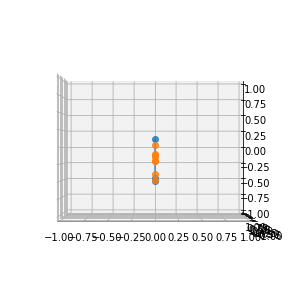

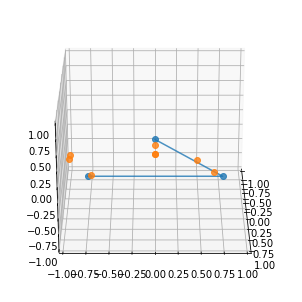

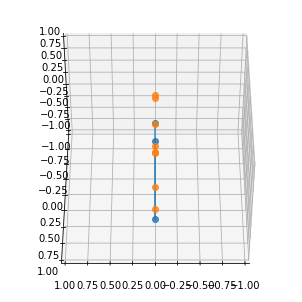

In [211]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for elevation, azimuth in zip([0, 25, 45], [-90, 0, 90]):
    fig = plt.figure()
    ax = Axes3D(fig, elev=elevation, azim=azimuth)
    a_p = np.array(atom_positions).T
    c_p = np.array(c_positions).T
    plt.plot(a_p[0], a_p[1], a_p[2], marker="o", alpha=0.8)
    #plt.scatter(1, 2, 2, marker="o")
    plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    plt.show()

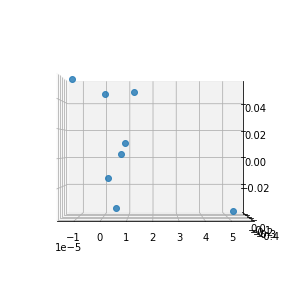

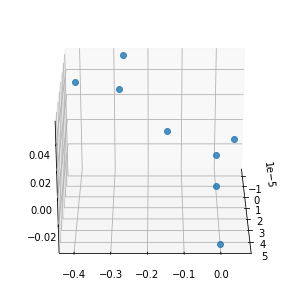

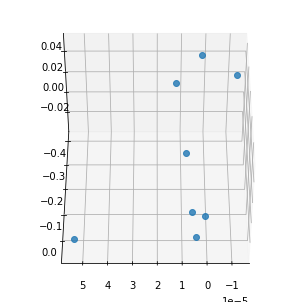

In [209]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for elevation, azimuth in zip([0, 25, 45], [-90, 0, 90]):
    fig = plt.figure()
    ax = Axes3D(fig, elev=elevation, azim=azimuth)
    a_p = np.array(atom_positions).T
    c_p = np.array(c_positions_local).T
    plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
    plt.show()